# XGBoost Architektur

#### Importe

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
from sklearn.model_selection import RandomizedSearchCV
from pathlib import Path

#### Gleichgewichtsdaten importieren

In [3]:
eq_data_file = Path.cwd().parent / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten
res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[H2,N2,NH3]
T = np.array(res['T'])
p = np.array(res['p'])
x_0 = np.array(res['x_0'])
x = np.array(res['x'])

#print(x_0)

X = np.stack((T, p, x_0[:,0], x_0[:,1], x_0[:,2]), axis = 1)
y = np.stack((x[:,0], x[:,2]), axis = 1) # [x_H2, x_NH3]
#print(X[:,0])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, random_state = 42)

#print(y_train)

#### Normalisierung

In [4]:
# Preprocessing Normalisierung der Daten
mean_in = np.mean(X_train, 0) # Mittelwert
std_in = np.std(X_train, 0) # Standardabweichung
mean_out = y_train.mean()
std_out = np.std(y_train, 0)

X_train = (X_train - mean_in) / std_in
y_train = (y_train - mean_out) / std_out

X_test = (X_test -mean_in) / std_in
y_test = (y_test - mean_out) / std_out

# print(mean_in)
# print(std_in)
# print(X_train)
# print(np.mean(X_train[:,0]))

#### DMatrix

In [5]:
# Erstellen von Regressionsmatrizen
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

#### Hyperparameter

In [43]:
# Definition von Hyperparametern
params = {"objective": "reg:squarederror",
          "max_depth": 6, #default=6
          "learning_rate": 0.3, #default= 0.3
          "colsample_bytree": 1, #default=1 fraction of columns to be randomly sampled for each tree; might improve overfitting
          "subsample": 1, #default=1  fraction of observations to be sampled for each tree
         }
evals = [(dtrain, "train"), (dtest, "validation")]

n = 10000

#### XGBoost Modell

In [44]:
xgb_model = xgb.train(params = params, 
                      dtrain = dtrain, 
                      num_boost_round = n, 
                      evals = evals, 
                      verbose_eval = 50, # gibt nur alle x Runden aus
                      early_stopping_rounds = 50 # bricht Training ab, wenn val_loss sich für x Runden nicht verbessert
                     )

#xgb_model.fit(X_train, y_train, eval_set = [(X_test, y_test)])
# score_xgb_train = xgb_model.score(X_train, y_train)
# score_xgb_test = xgb_model.score(X_test, y_test)
# print('R^2 Train:', score_xgb_train)
# print('R^2 Test:', score_xgb_test)

[0]	train-rmse:1.37897	validation-rmse:1.39883
[50]	train-rmse:0.01455	validation-rmse:0.11427
[100]	train-rmse:0.00454	validation-rmse:0.11355
[150]	train-rmse:0.00172	validation-rmse:0.11325
[200]	train-rmse:0.00156	validation-rmse:0.11324
[203]	train-rmse:0.00156	validation-rmse:0.11324


#### Vorhersage Gleichgewichtsdaten

In [46]:
# Vorhersage der GGW Daten
pred_train_norm = xgb_model.predict(dtrain)
pred_test_norm = xgb_model.predict(dtest)

# Denormalisierung
pred_train = pred_train_norm * std_out + mean_out
real_train = y_train * std_out + mean_out
pred_test = pred_test_norm * std_out + mean_out
real_test = y_test * std_out + mean_out

mae_train = (abs(real_train - pred_train)).mean()
mae_test = (abs(real_test - pred_test)).mean()
mre_train = (abs((real_train - pred_train) / real_train)).mean()
mre_test = (abs((real_test - pred_test) / real_test)).mean()

print('MAE Train:', mae_train, 'MRE Train:', mre_train, 'MAE Test:', mae_test, 'MRE Test:', mre_test)

MAE Train: 0.00014951724986615606 MRE Train: 0.0006581184902556336 MAE Test: 0.010558692555530175 MRE Test: 0.05027175856074777


#### Parity Plot

Training Dataset: R^2 = 0.9999975725841865
Test Dataset: R^2 = 0.9867322071537873
Max Error Training: |x_H2 - x_H2_pred| = 0.0005605784064041108 |x_NH3 - x_NH3_pred| = 0.0002726836468506799
Max Error Test: |x_H2 - x_H2_pred| = 0.0030843750670547787 |x_NH3 - x_NH3_pred| = 0.047138612237012434


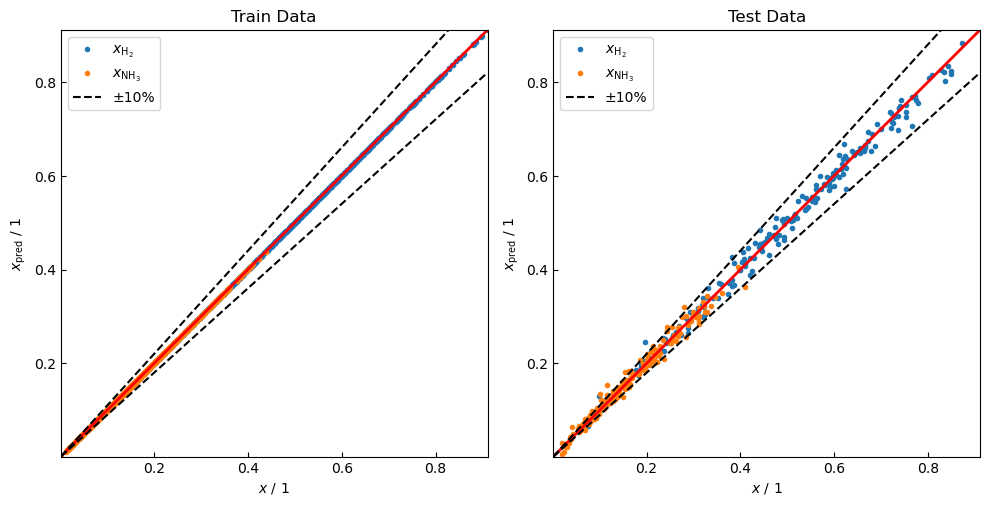

In [47]:
print('Training Dataset: R^2 =', r2(real_train,pred_train))
print('Test Dataset: R^2 =', r2(real_test,pred_test))
print('Max Error Training: |x_H2 - x_H2_pred| =', max_error(real_train[0], pred_train[0]), '|x_NH3 - x_NH3_pred| =', max_error(real_train[1], pred_train[1]))
print('Max Error Test: |x_H2 - x_H2_pred| =', max_error(real_test[0], pred_test[0]), '|x_NH3 - x_NH3_pred| =', max_error(real_test[1], pred_test[1]))

# find the boundaries of X and Y values
bounds = (min(real_train.min(), pred_train.min()) - int(0.1 * pred_train.min()), max(real_train.max(), pred_train.max())+ int(0.1 * pred_train.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(real_train, pred_train, '.', label = (['$x\mathregular{_{H_2}}$', '$x\mathregular{_{NH_3}}$']))
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", label = ('\xb1' '10%')) # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--") # Error line
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(real_test, pred_test, '.', label = (['$x\mathregular{_{H_2}}$', '$x\mathregular{_{NH_3}}$']))
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", label = ('\xb1' '10%')) # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--") # Error line
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Cross-Validation

In [48]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 1000

results = xgb.cv(
   params, dtrain,
   num_boost_round = n,
   nfold = 5,
   early_stopping_rounds = 20
)
print(results.head())

best_loss, best_round = results['test-rmse-mean'].min(), results['test-rmse-mean'].idxmin()
print('Best loss:', best_loss, 'Round:', best_round)

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         1.380653        0.007482        1.384559       0.035164
1         0.987312        0.005327        0.998745       0.027710
2         0.709325        0.003942        0.727808       0.022920
3         0.513083        0.002584        0.539768       0.019523
4         0.373660        0.002223        0.410636       0.017865
Best loss: 0.13619075966589303 Round: 118


#### GridSearch CV

In [58]:
# Liste der zu tunenden Hyperparameter
params = {"objective": ["reg:squarederror", "reg:squaredlogerror", "reg:logistic", "reg:pseudohubererror", "reg:absoluteerror"],
          "max_depth": [3, 5, 6, 10, 15], #default=6
          "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4], #default= 0.3
          "colsample_bytree": np.arange(0.4, 1.0, 0.1), #default=1 fraction of columns to be randomly sampled for each tree; might improve overfitting
          "subsample": np.arange(0.5, 1.0, 0.1), #default=1  fraction of observations to be sampled for each tree
          "colsample_bylevel": np.arange(0.4, 1.0, 0.1),
          "n_estimators": np.arange(50, 1000, 10)
         }

# Neues XGBoost Objekt
knn_model_2 = xgb.XGBRegressor()

model = RandomizedSearchCV(knn_model_2, params, n_iter=25)
best_model = model.fit(X_train, y_train)

print('Best parameters:', best_model.best_params_)
best_objective = best_model.best_estimator_.get_params()['objective']
best_max_depth = best_model.best_estimator_.get_params()['max_depth']
best_learning_rate = best_model.best_estimator_.get_params()['learning_rate']
best_colsample_bytree = best_model.best_estimator_.get_params()['colsample_bytree']
best_subsample = best_model.best_estimator_.get_params()['subsample']
best_colsample_bylevel = best_model.best_estimator_.get_params()['colsample_bylevel']
best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

C:\Users\sinar\anaconda3\envs\BA\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
55 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sinar\anaconda3\envs\BA\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sinar\anaconda3\envs\BA\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\sinar\anaconda3\envs\BA\lib\site-packages\xgboost\sklearn.py", line 1025, in fit
    self._Booster = train(
  File "C:\Users\sinar\anaconda3\envs\BA\lib\

Best parameters: {'subsample': 0.6, 'objective': 'reg:squarederror', 'n_estimators': 990, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.4}


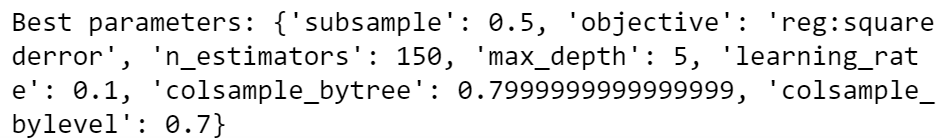

#### Best Model

In [55]:
xgb_model_2 = xgb.train(params = best_model.best_params_, 
                      dtrain = dtrain, 
                      num_boost_round = n, 
                      evals = evals, 
                      verbose_eval = 50, # gibt nur alle x Runden aus
                      early_stopping_rounds = 50 # bricht Training ab, wenn val_loss sich für x Runden nicht verbessert
                     )
#xgb_model_2 = xgb.XGBRegressor('subsample': 0.5, 'objective': 'reg:squarederror', 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.7) # Initialisierung
#xgb_model_2 = xgb.XGBRegressor(best_model.best_params_) # Initialisierung

# xgb_model_2.fit(X_train, y_train, eval_set = [(X_test, y_test)])

# score_xgb_train = xgb_model.score(X_train, y_train)
# score_xgb_test = xgb_model.score(X_test, y_test)
# print('R^2 Train:', score_xgb_train)
# print('R^2 Test:', score_xgb_test)

[10:46:39] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-rmse:1.76326	validation-rmse:1.78423
[50]	train-rmse:0.07090	validation-rmse:0.12664
[100]	train-rmse:0.04173	validation-rmse:0.10246
[150]	train-rmse:0.03025	validation-rmse:0.09697
[200]	train-rmse:0.02244	validation-rmse:0.09476
[250]	train-rmse:0.01702	validation-rmse:0.09348
[300]	train-rmse:0.01347	validation-rmse:0.09285
[350]	train-rmse:0.01056	validation-rmse:0.09219
[400]	train-rmse:0.00839	validation-rmse:0.09172
[450]	train-rmse:0.00676	validation-rmse:0.09131
[500]	train-rmse:0.00543	validation-rmse:0.09094
[550]	train-rmse:0.00438	validation-rmse:0.09067
[600]	train-rmse:0.00355	validation-rmse:0.09056
[650]	train-rmse:0.00287	validation-rmse:0.09062
[664]	train-rmse:0.00271	validation-rmse:0.09059


In [56]:
# Vorhersage der GGW Daten
pred_train_norm = xgb_model_2.predict(dtrain)
pred_test_norm = xgb_model_2.predict(dtest)

# Denormalisierung
pred_train = pred_train_norm * std_out + mean_out
real_train = y_train * std_out + mean_out
pred_test = pred_test_norm * std_out + mean_out
real_test = y_test * std_out + mean_out

mae_train = (abs(real_train - pred_train)).mean()
mae_test = (abs(real_test - pred_test)).mean()
mre_train = (abs((real_train - pred_train) / real_train)).mean()
mre_test = (abs((real_test - pred_test) / real_test)).mean()

print('MAE Train:', mae_train, 'MRE Train:', mre_train, 'MAE Test:', mae_test, 'MRE Test:', mre_test)

MAE Train: 0.0002562952295150919 MRE Train: 0.001450257071016328 MAE Test: 0.008525939786861496 MRE Test: 0.0419587699209864


Training Dataset: R^2 = 0.999992695691272
Test Dataset: R^2 = 0.9914450522499021
Max Error Training: |x_H2 - x_H2_pred| = 0.00021572060564006845 |x_NH3 - x_NH3_pred| = 0.0006896442590248741
Max Error Test: |x_H2 - x_H2_pred| = 0.007760505371832538 |x_NH3 - x_NH3_pred| = 0.02852465834567547


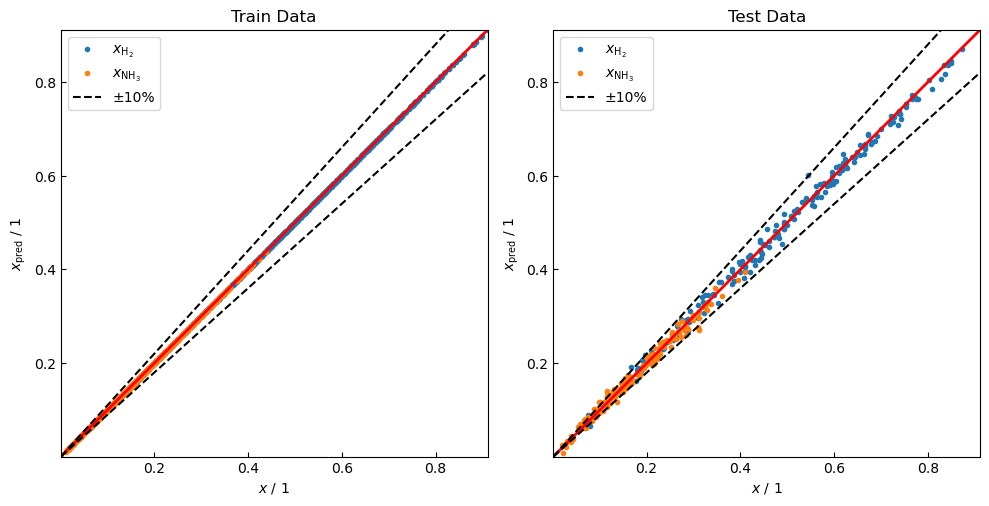

In [57]:
print('Training Dataset: R^2 =', r2(real_train,pred_train))
print('Test Dataset: R^2 =', r2(real_test,pred_test))
print('Max Error Training: |x_H2 - x_H2_pred| =', max_error(real_train[0], pred_train[0]), '|x_NH3 - x_NH3_pred| =', max_error(real_train[1], pred_train[1]))
print('Max Error Test: |x_H2 - x_H2_pred| =', max_error(real_test[0], pred_test[0]), '|x_NH3 - x_NH3_pred| =', max_error(real_test[1], pred_test[1]))

# find the boundaries of X and Y values
bounds = (min(real_train.min(), pred_train.min()) - int(0.1 * pred_train.min()), max(real_train.max(), pred_train.max())+ int(0.1 * pred_train.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(real_train, pred_train, '.', label = (['$x\mathregular{_{H_2}}$', '$x\mathregular{_{NH_3}}$']))
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", label = ('\xb1' '10%')) # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--") # Error line
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(real_test, pred_test, '.', label = (['$x\mathregular{_{H_2}}$', '$x\mathregular{_{NH_3}}$']))
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", label = ('\xb1' '10%')) # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--") # Error line
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()